In [1]:
from datasets import load_dataset
from transformers import RobertaTokenizer,RobertaForSequenceClassification
import random
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# Loading Dataset

In [2]:
ag_news_dataset = load_dataset("ag_news").shuffle(seed = 27)

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [39]:
ag_news_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [3]:
label_mapping = {
    0:"World",
    1:"Sports",
    2:"Business",
    3:"Sci/Tech"
}

In [4]:
def dataset_head():
    head=[]
    for _ in range(10):
        idx=random.randint(0,len(ag_news_dataset['train'])-1)
        head.append(idx)
    df = pd.DataFrame(ag_news_dataset['train'][head])
    df['label_decoded'] = [label_mapping[int(x)] for x in df['label']]
    return df
dataset_head()

,text,label,label_decoded
0,"Oil Up 4 Pct, Heating Oil Supplies Fall LONDO...",2,Business
1,Gallacher #39;s wedge shot wraps up #39;dream...,1,Sports
2,Singh eclipses Tiger with record pile Farmingt...,1,Sports
3,"Snow Supports Strong Dollar, #39; Says Markets...",2,Business
4,Wizards Pound Hornets Washington forces a slop...,1,Sports
5,"Cardinals' La Russa: A Man for All Seasons, Ex...",1,Sports
6,Dell Axim X50 and X50v Pocket PC reviews round...,3,Sci/Tech
7,Ex-Kosovo Rebels Face First Hague War Crimes T...,0,World
8,"Boston College 24, No. 24 Notre Dame 23 Paul P...",1,Sports
9,British hostage reportedly still alive in Iraq...,0,World


# Initializing tokenizer and helper functions
We pass every sentence in the dataset into the tokenizer. `max_length` is fixed as 64 so that every encoding is of the same length

In [5]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [6]:
def tokenizer_helper(sentences):
    # print(sentences)
    return tokenizer(sentences['text'],truncation=True,max_length=64,padding='max_length')

In [7]:
# Seperating the train and test dataset
train_dataset = ag_news_dataset['train'].map(tokenizer_helper,batched=True)
test_dataset= ag_news_dataset['test'].map(tokenizer_helper,batched=True)

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [8]:
# Extracting the input ids, labels and attention masks
train_dataset_seq = train_dataset['input_ids']
train_dataset_labels = train_dataset['label']
train_dataset_masks = train_dataset['attention_mask']

test_dataset_seq = test_dataset['input_ids']
test_dataset_labels = test_dataset['label']
test_dataset_masks = test_dataset['attention_mask']


In [9]:
# Converting the above data into torch tensors
train_dataset_seq = torch.Tensor(train_dataset_seq)
train_dataset_labels = torch.Tensor(train_dataset_labels)
train_dataset_masks =torch.Tensor(train_dataset_masks)
test_dataset_seq = torch.Tensor(test_dataset_seq)
test_dataset_labels = torch.Tensor(test_dataset_labels)
test_dataset_masks =torch.Tensor(test_dataset_masks)

In [11]:
from tqdm import tqdm
from torch.utils.data import TensorDataset,DataLoader, RandomSampler
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score

In [20]:
BATCH_SIZE = 64
EPOCHS = 5
DEVICE = 'cuda'
#Wrapping up train dataset into dataloader
train_tensor_dataset = TensorDataset(train_dataset_seq,train_dataset_masks,train_dataset_labels)
train_sampler = RandomSampler(train_tensor_dataset)
train_dataloader = DataLoader(train_tensor_dataset,sampler=train_sampler,batch_size=BATCH_SIZE)

#Wrapping up validation dataset into dataloader
val_tensor_dataset = TensorDataset(test_dataset_seq,test_dataset_masks,test_dataset_labels)
val_sampler = RandomSampler(val_tensor_dataset)
val_dataloader = DataLoader(val_tensor_dataset,sampler=val_sampler,batch_size=BATCH_SIZE)

#initialize model and change the last layer output size to 4 
model = RobertaForSequenceClassification.from_pretrained("roberta-base")
model.classifier.out_proj = torch.nn.Linear(768,4)
model = model.to(DEVICE)

# initialize the optimizer, loss and learningrate scheduler
optimizer = optim.Adam(model.parameters(),lr = 2e-5)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.9)
loss = nn.CrossEntropyLoss()

#tracking variables
macro_precisions=[]
macro_recalls=[]
macro_f1s=[]
#Progress bar
pbar = tqdm(range(EPOCHS),position=0,leave=True)


# Training loop
for epoch in pbar:
    model.train()
    train_loss=0
    accuracy = 0
    tbar = tqdm(train_dataloader,position=0,leave=True)
    #Iterate over batches
    for batch in tbar:
        #First move batches to GPU and convert int and float to long datatype
        batch = [t.to(DEVICE) for t in batch]
        seq,mask,labels = batch
        seq = seq.to(torch.long)
        mask = mask.to(torch.long)
        labels = labels.to(torch.long)

        
        model.zero_grad()

        #Get predictions
        preds = model(seq,mask).logits
        batch_loss = loss(preds,labels)
        train_loss+=batch_loss.item()

        #Update gradients
        batch_loss.backward()
        #Clip grads to prevent explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
        optimizer.step()

        #Get training accuracy
        soft_preds = nn.Softmax()(preds)
        pred_class = torch.argmax(soft_preds,dim=1)
        accuracy = (pred_class == labels).sum() / BATCH_SIZE

        #Progress bar stuffs
        tbar.set_description(f"loss = {train_loss}  accuracy = {accuracy}")
        tbar.refresh() # to show immediately the update
    
    #Validation accuracy and loss tracking
    model.eval()
    val_acc=0
    val_loss=0
    v_idx=0
    y_true=torch.Tensor([]).to(DEVICE)
    y_pred=torch.Tensor([]).to(DEVICE)

    for batch in val_dataloader:
        #First move batches to GPU and convert int and float to long datatype
        batch = [t.to(DEVICE) for t in batch]
        seq,mask,labels = batch
        seq = seq.to(torch.long)
        mask = mask.to(torch.long)
        labels = labels.to(torch.long)
        #Get predictions
        preds = model(seq,mask).logits
        val_loss+= loss(preds,labels).item()
        soft_preds = nn.Softmax()(preds)
        pred_class = torch.argmax(soft_preds,dim=1)
        #Get the validation accuracy percentage
        val_acc += (pred_class == labels).sum() / BATCH_SIZE
        v_idx+=1
        y_true = torch.cat((y_true,labels))
        y_pred = torch.cat((y_pred,pred_class))
    
    # Calculate Macro Precision, Recall, F1
    macro_precision = precision_score(y_true.cpu(), y_pred.cpu(), average='macro')
    macro_recall = recall_score(y_true.cpu(), y_pred.cpu(), average='macro')
    macro_f1 = f1_score(y_true.cpu(), y_pred.cpu(), average='macro')
    
    print({'val_acc': val_acc/v_idx,'val_loss':val_loss/v_idx})
    print({'macro_precision':macro_precision,'macro_recall':macro_recall,'macro_f1':macro_f1})
    macro_precisions.append(macro_precision)
    macro_recalls.append(macro_recall)
    macro_f1s.append(macro_f1)
           
    #Step Learning Rate
    lr_scheduler.step()
    


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

{'val_acc': tensor(0.9388, device='cuda:0'), 'val_loss': 0.18388852757253066}
{'macro_precision': 0.941185043241485, 'macro_recall': 0.9407894736842105, 'macro_f1': 0.9408406756076862}


  0%|          | 0/1875 [00:00<?, ?it/s]/tmp/ipykernel_600/2716866438.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  soft_preds = nn.Softmax()(preds)
loss = 274.57140460424125  accuracy = 0.953125: 100%|██████████| 1875/1875 [02:48<00:00, 11.10it/s]
/tmp/ipykernel_600/2716866438.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  soft_preds = nn.Softmax()(preds)
 40%|████      | 2/5 [05:43<08:35, 171.71s/it]

{'val_acc': tensor(0.9422, device='cuda:0'), 'val_loss': 0.17681024588268845}
{'macro_precision': 0.9447833361599921, 'macro_recall': 0.9442105263157894, 'macro_f1': 0.9441816787215507}


  0%|          | 0/1875 [00:00<?, ?it/s]/tmp/ipykernel_600/2716866438.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  soft_preds = nn.Softmax()(preds)
loss = 209.7871038033627  accuracy = 0.96875: 100%|██████████| 1875/1875 [02:48<00:00, 11.14it/s]  
/tmp/ipykernel_600/2716866438.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  soft_preds = nn.Softmax()(preds)
 60%|██████    | 3/5 [08:34<05:43, 171.53s/it]

{'val_acc': tensor(0.9450, device='cuda:0'), 'val_loss': 0.1702744692970975}
{'macro_precision': 0.9472135378269874, 'macro_recall': 0.9469736842105263, 'macro_f1': 0.9469974104230758}


  0%|          | 0/1875 [00:00<?, ?it/s]/tmp/ipykernel_600/2716866438.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  soft_preds = nn.Softmax()(preds)
loss = 161.8933010972105  accuracy = 0.9375: 100%|██████████| 1875/1875 [02:48<00:00, 11.16it/s]   
/tmp/ipykernel_600/2716866438.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  soft_preds = nn.Softmax()(preds)
 80%|████████  | 4/5 [11:25<02:51, 171.34s/it]

{'val_acc': tensor(0.9484, device='cuda:0'), 'val_loss': 0.17554165922230533}
{'macro_precision': 0.9507650783456986, 'macro_recall': 0.9503947368421053, 'macro_f1': 0.9505181696207576}


  0%|          | 0/1875 [00:00<?, ?it/s]/tmp/ipykernel_600/2716866438.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  soft_preds = nn.Softmax()(preds)
loss = 124.59022658737376  accuracy = 1.0: 100%|██████████| 1875/1875 [02:48<00:00, 11.10it/s]     
/tmp/ipykernel_600/2716866438.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  soft_preds = nn.Softmax()(preds)
100%|██████████| 5/5 [14:17<00:00, 171.52s/it]

{'val_acc': tensor(0.9467, device='cuda:0'), 'val_loss': 0.20813293677672526}
{'macro_precision': 0.9486707228274305, 'macro_recall': 0.9486842105263159, 'macro_f1': 0.9486463304954357}


In [21]:
#Save Best model
torch.save(model,"FinalModel.pt")

# Plot the graphs for Macro Precision, Macro F1 and Macro Recall

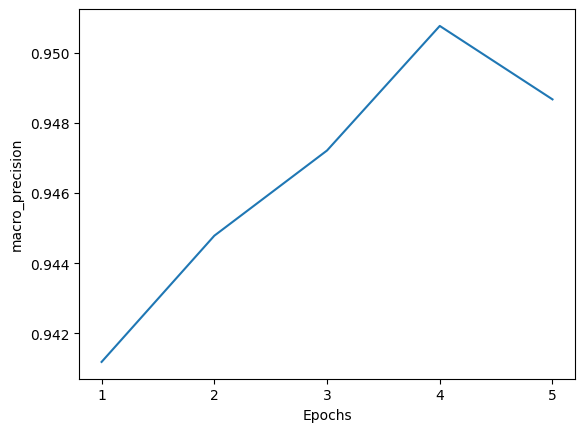

In [31]:
plt.plot([1,2,3,4,5],macro_precisions,label="macro_precision")
plt.xticks(np.arange(1, 6, 1.0))
plt.xlabel("Epochs")
plt.ylabel("macro_precision")
plt.show()

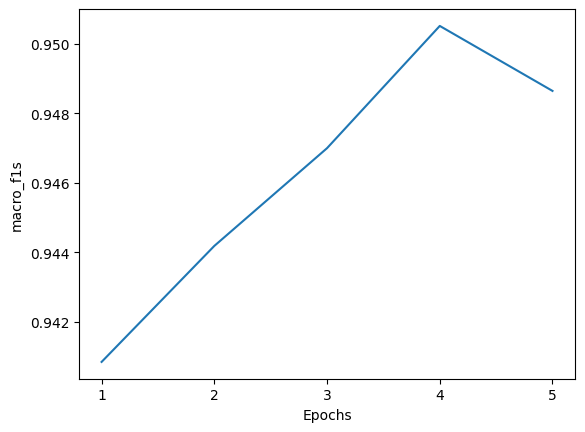

In [32]:
plt.plot([1,2,3,4,5],macro_f1s,label="macro_f1s")
plt.xticks(np.arange(1, 6, 1.0))
plt.xlabel("Epochs")
plt.ylabel("macro_f1s")
plt.show()

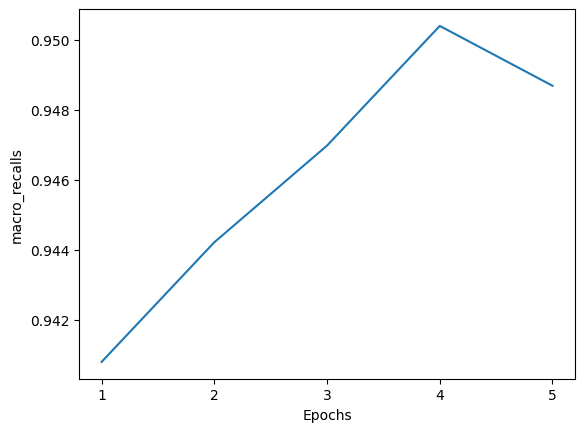

In [33]:
plt.plot([1,2,3,4,5],macro_recalls,label="macro_recalls")
plt.xticks(np.arange(1, 6, 1.0))
plt.xlabel("Epochs")
plt.ylabel("macro_recalls")
plt.show()